In [8]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, precision_recall_curve, auc)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import optuna

%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

df_train = pd.read_csv("train_c.csv")
df_test = pd.read_csv("test_c.csv")

print(f"Train shape: {df_train.shape}")
print(f"Test shape:  {df_test.shape}")
df_train.head()

Train shape: (11017, 35)
Test shape:  (5000, 35)


,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,JobTenure,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,4.0,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,2.0,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,3.0,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,3.0,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,5.0,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0


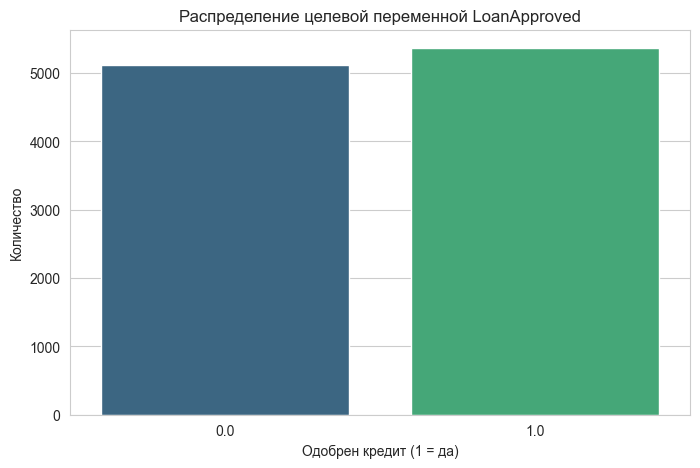

Доля одобренных кредитов: 0.5117764851721178


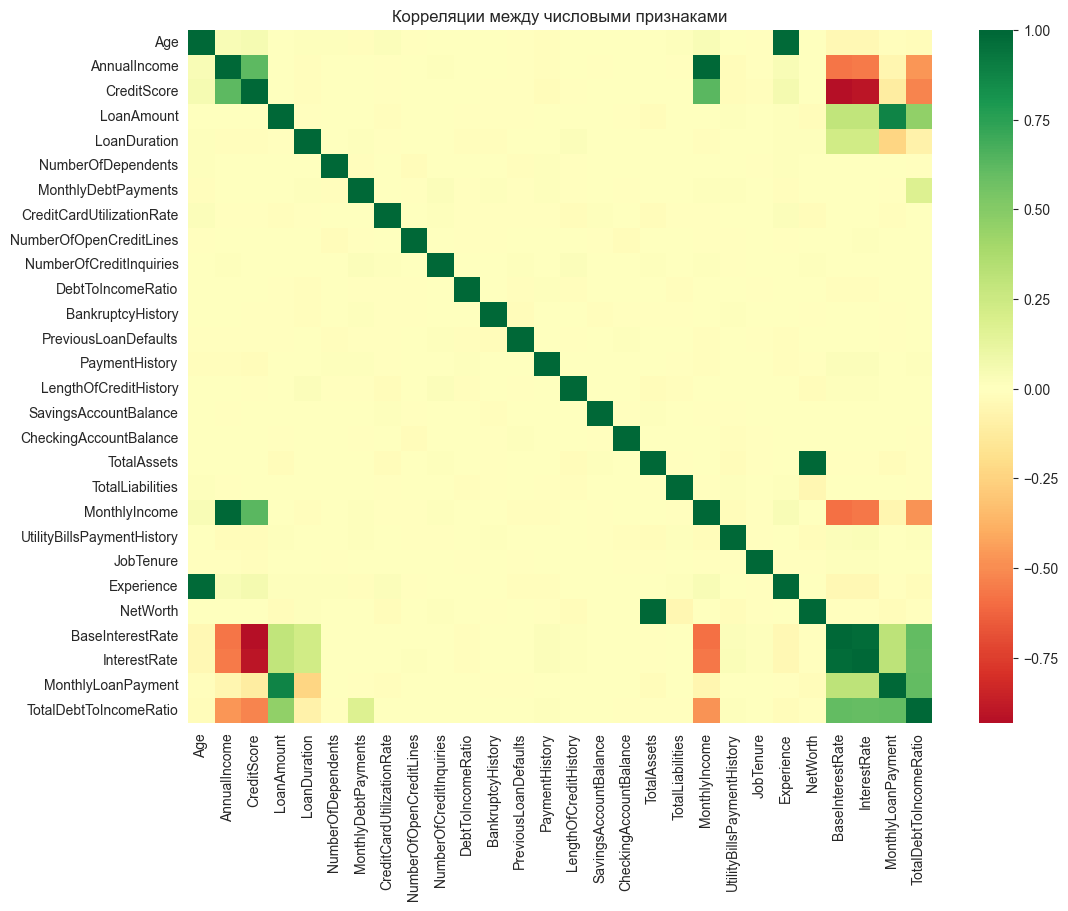

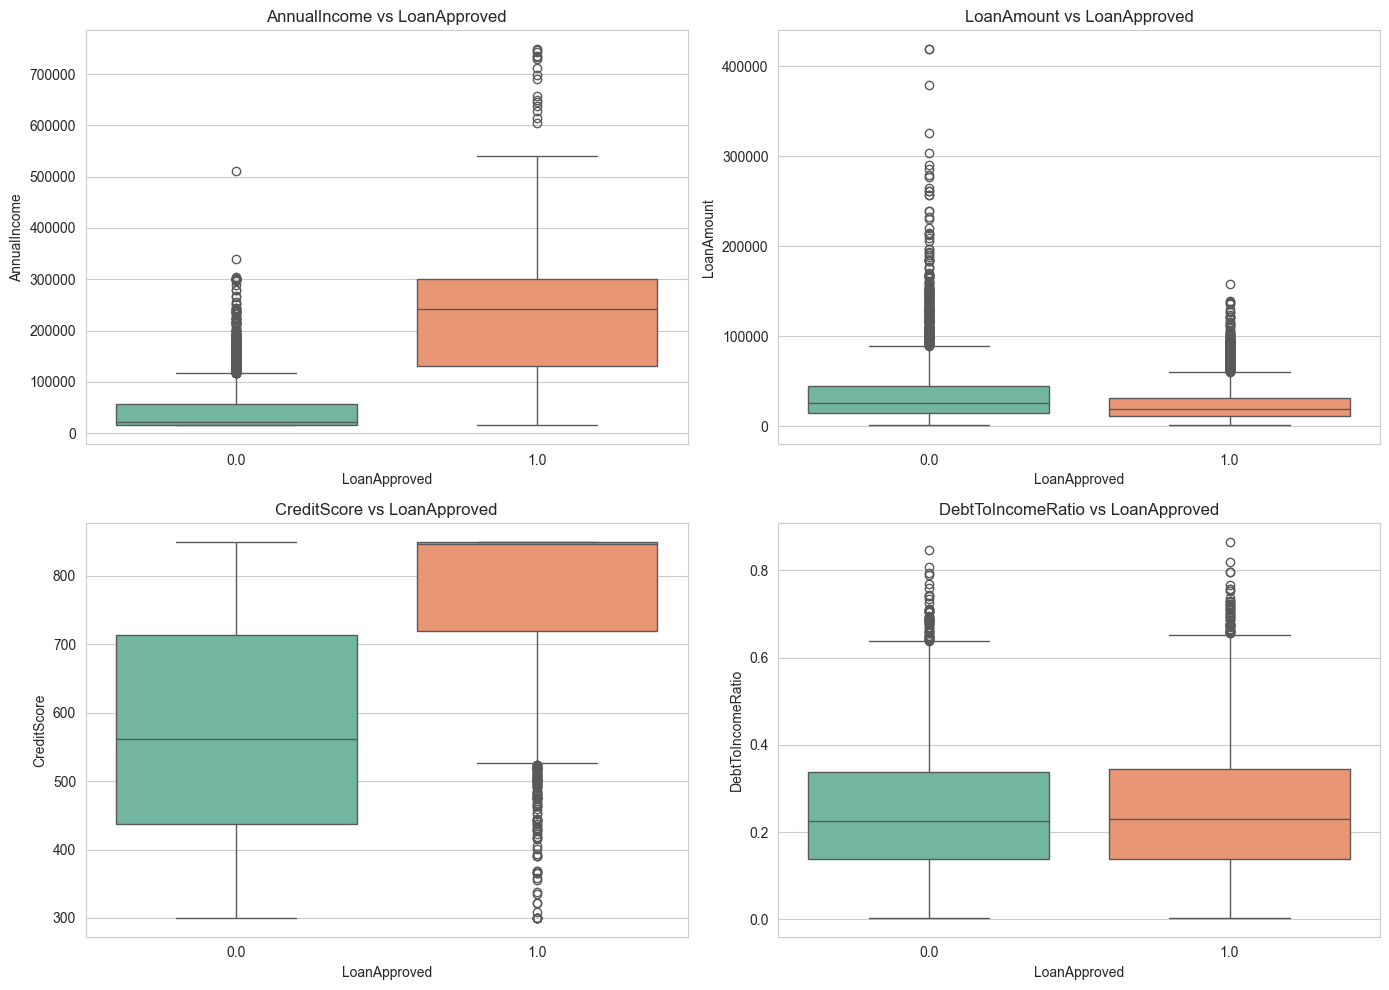

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_train, x='LoanApproved', palette='viridis')
plt.title('Распределение целевой переменной LoanApproved')
plt.xlabel('Одобрен кредит (1 = да)')
plt.ylabel('Количество')
plt.show()

print("Доля одобренных кредитов:", df_train['LoanApproved'].mean())

numeric_cols = df_train.select_dtypes(include=np.number).columns.drop('LoanApproved')
corr_matrix = df_train[numeric_cols].corr()

plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=False, cmap='RdYlGn', center=0)
plt.title('Корреляции между числовыми признаками')
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.boxplot(data=df_train, x='LoanApproved', y='AnnualIncome', ax=axes[0,0], palette='Set2')
axes[0,0].set_title('AnnualIncome vs LoanApproved')

sns.boxplot(data=df_train, x='LoanApproved', y='LoanAmount', ax=axes[0,1], palette='Set2')
axes[0,1].set_title('LoanAmount vs LoanApproved')

sns.boxplot(data=df_train, x='LoanApproved', y='CreditScore', ax=axes[1,0], palette='Set2')
axes[1,0].set_title('CreditScore vs LoanApproved')

sns.boxplot(data=df_train, x='LoanApproved', y='DebtToIncomeRatio', ax=axes[1,1], palette='Set2')
axes[1,1].set_title('DebtToIncomeRatio vs LoanApproved')

plt.tight_layout()
plt.show()

In [10]:
for data in [df_train, df_test]:
    if 'ApplicationDate' in data.columns:
        data['ApplicationDate'] = pd.to_datetime(data['ApplicationDate'])
        data['Year']  = data['ApplicationDate'].dt.year
        data['Month'] = data['ApplicationDate'].dt.month
        data['Day']   = data['ApplicationDate'].dt.day
        data.drop('ApplicationDate', axis=1, inplace=True)

test_ids = df_test['ID'].copy()
df_test.drop('ID', axis=1, inplace=True)

num_features = df_train.select_dtypes(include=np.number).columns.drop('LoanApproved')
cat_features = df_train.select_dtypes(exclude=np.number).columns

num_imputer = SimpleImputer(strategy='mean')
df_train[num_features] = num_imputer.fit_transform(df_train[num_features])
df_test[num_features]  = num_imputer.transform(df_test[num_features])

if len(cat_features) > 0:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df_train[cat_features] = cat_imputer.fit_transform(df_train[cat_features])
    df_test[cat_features]  = cat_imputer.transform(df_test[cat_features])

for col in df_train.select_dtypes(include='object').columns:
    encoder = LabelEncoder()
    df_train[col] = encoder.fit_transform(df_train[col].astype(str))
    df_test[col]  = encoder.transform(df_test[col].astype(str))

print("Пропусков в LoanApproved:", df_train['LoanApproved'].isna().sum())
df_train['LoanApproved'].fillna(df_train['LoanApproved'].median(), inplace=True)

target = df_train['LoanApproved']
features = df_train.drop('LoanApproved', axis=1)

df_test = df_test[features.columns]

X_train, X_valid, y_train, y_valid = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)

Пропусков в LoanApproved: 530


In [11]:
class CustomBaggingClassifier:
    def __init__(self, base_estimator=DecisionTreeClassifier, n_estimators=30, max_depth=None, seed=42):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.seed = seed
        self.estimators_ = []

    def fit(self, X, y):
        np.random.seed(self.seed)
        n_samples = X.shape[0]
        self.estimators_ = []

        for _ in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            model = self.base_estimator(max_depth=self.max_depth)
            model.fit(X.iloc[indices], y.iloc[indices])
            self.estimators_.append(model)
        return self

    def predict_proba(self, X):
        probs = np.mean([est.predict_proba(X)[:, 1] for est in self.estimators_], axis=0)
        return probs

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

custom_bag = CustomBaggingClassifier(
    base_estimator=DecisionTreeClassifier, n_estimators=30, max_depth=6, seed=123)
custom_bag.fit(X_train, y_train)

sklearn_bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=6), n_estimators=30, random_state=123)
sklearn_bag.fit(X_train, y_train)

print("Custom Bagging ROC-AUC:", roc_auc_score(y_valid, custom_bag.predict_proba(X_valid)))
print("Sklearn Bagging ROC-AUC:", roc_auc_score(y_valid, sklearn_bag.predict_proba(X_valid)[:,1]))

Custom Bagging ROC-AUC: 0.9761218054819916
Sklearn Bagging ROC-AUC: 0.975608696371822


In [12]:
def stable_sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -30, 30)))

class CustomGradientBoosting:
    def __init__(self, n_trees=120, lr=0.1, tree_depth=4, seed=42):
        self.n_trees = n_trees
        self.lr = lr
        self.tree_depth = tree_depth
        self.seed = seed
        self.trees = []
        self.initial_pred = 0.0

    def fit(self, X, y):
        p = y.mean()
        self.initial_pred = np.log(p / (1 - p + 1e-8))
        current_pred = np.full(len(y), self.initial_pred)

        rng = np.random.RandomState(self.seed)
        for _ in range(self.n_trees):
            prob = stable_sigmoid(current_pred)
            residuals = y - prob
            tree = DecisionTreeRegressor(max_depth=self.tree_depth,
                                         random_state=rng.randint(1_000_000))
            tree.fit(X, residuals)
            current_pred += self.lr * tree.predict(X)
            self.trees.append(tree)
        return self

    def predict_proba(self, X):
        pred = np.full(len(X), self.initial_pred)
        for tree in self.trees:
            pred += self.lr * tree.predict(X)
        return stable_sigmoid(pred)

custom_gb = CustomGradientBoosting(n_trees=120, lr=0.1, tree_depth=4, seed=2025)
custom_gb.fit(X_train, y_train)

print("Custom GB ROC-AUC:", roc_auc_score(y_valid, custom_gb.predict_proba(X_valid)))

Custom GB ROC-AUC: 0.9783248642743644


In [13]:
def custom_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def custom_precision(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp) if (tp + fp) > 0 else 0.0

def custom_recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn) if (tp + fn) > 0 else 0.0

def custom_f1(y_true, y_pred):
    p = custom_precision(y_true, y_pred)
    r = custom_recall(y_true, y_pred)
    return 2 * p * r / (p + r) if (p + r) > 0 else 0.0

pred_custom = (custom_gb.predict_proba(X_valid) >= 0.5).astype(int)

print("=== Сравнение метрик ===")
print(f"Accuracy  — custom: {custom_accuracy(y_valid.values, pred_custom):.5f} | sklearn: {accuracy_score(y_valid, pred_custom):.5f}")
print(f"Precision — custom: {custom_precision(y_valid.values, pred_custom):.5f} | sklearn: {precision_score(y_valid, pred_custom):.5f}")
print(f"Recall    — custom: {custom_recall(y_valid.values, pred_custom):.5f} | sklearn: {recall_score(y_valid, pred_custom):.5f}")
print(f"F1-score  — custom: {custom_f1(y_valid.values, pred_custom):.5f} | sklearn: {f1_score(y_valid, pred_custom):.5f}")

=== Сравнение метрик ===
Accuracy  — custom: 0.92514 | sklearn: 0.92514
Precision — custom: 0.92611 | sklearn: 0.92611
Recall    — custom: 0.93475 | sklearn: 0.93475
F1-score  — custom: 0.93041 | sklearn: 0.93041


In [14]:
models_comparison = {}

sklearn_gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05,
                                        max_depth=4, random_state=42)
sklearn_gb.fit(X_train, y_train)
models_comparison['Sklearn GB'] = sklearn_gb.predict_proba(X_valid)[:,1]

xgb_model = xgb.XGBClassifier(n_estimators=400, max_depth=6, learning_rate=0.05,
                              subsample=0.9, colsample_bytree=0.9,
                              random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
models_comparison['XGBoost'] = xgb_model.predict_proba(X_valid)[:,1]

lgb_model = lgb.LGBMClassifier(n_estimators=600, learning_rate=0.05, num_leaves=50,
                               subsample=0.9, colsample_bytree=0.9, random_state=42)
lgb_model.fit(X_train, y_train)
models_comparison['LightGBM'] = lgb_model.predict_proba(X_valid)[:,1]

cat_model = cb.CatBoostClassifier(iterations=800, depth=7, learning_rate=0.05,
                                  l2_leaf_reg=5, random_state=42, verbose=0)
cat_model.fit(X_train, y_train)
models_comparison['CatBoost'] = cat_model.predict_proba(X_valid)[:,1]

print("=== ROC-AUC на валидации ===")
for name, proba in models_comparison.items():
    score = roc_auc_score(y_valid, proba)
    print(f"{name:12} → {score:.6f}")

[LightGBM] [Info] Number of positive: 4717, number of negative: 4096
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4686
[LightGBM] [Info] Number of data points in the train set: 8813, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535232 -> initscore=0.141162
[LightGBM] [Info] Start training from score 0.141162
=== ROC-AUC на валидации ===
Sklearn GB   → 0.983309
XGBoost      → 0.983886
LightGBM     → 0.983724
CatBoost     → 0.984805


In [16]:
import optuna
import numpy as np
import catboost as cb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

def objective(trial, features, target):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1000),
        'depth': trial.suggest_int('depth', 5, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 2.0),
        'verbose': 0,
        'random_state': 42,
        'task_type': 'CPU',
        'thread_count': -1,
        'bootstrap_type': 'Bayesian',
        'allow_writing_files': False,
        'early_stopping_rounds': 50,
        'od_type': 'Iter',
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in cv.split(features, target):
        train_pool = cb.Pool(
            features.iloc[train_idx],
            target.iloc[train_idx],
            thread_count=-1
        )
        val_pool = cb.Pool(
            features.iloc[val_idx],
            target.iloc[val_idx],
            thread_count=-1
        )

        model = cb.CatBoostClassifier(**params)
        model.fit(
            train_pool,
            eval_set=val_pool,
            verbose=False,
            use_best_model=True
        )

        pred = model.predict_proba(val_pool)[:, 1]
        scores.append(roc_auc_score(target.iloc[val_idx], pred))
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(scores)

study = optuna.create_study(
    direction='maximize',
    study_name='catboost_optimization',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=30),
    sampler=optuna.samplers.TPESampler(seed=42, multivariate=True)
)

study.optimize(
    lambda trial: objective(trial, features, target),
    n_trials=100,
    timeout=1800,
    n_jobs=1
    gc_after_trial=True
)

print("Лучшие параметры:", study.best_params)
print("Лучший ROC-AUC (CV):", study.best_value)

[I 2025-12-15 00:18:37,953] A new study created in memory with name: catboost_optimization
[I 2025-12-15 00:19:21,795] Trial 0 finished with value: 0.9860242868837693 and parameters: {'iterations': 687, 'depth': 10, 'learning_rate': 0.07587945476302646, 'l2_leaf_reg': 6.387926357773329, 'bagging_temperature': 0.15601864044243652, 'random_strength': 0.3119890406724053}. Best is trial 0 with value: 0.9860242868837693.
[I 2025-12-15 00:20:13,944] Trial 1 finished with value: 0.9858762665086669 and parameters: {'iterations': 529, 'depth': 10, 'learning_rate': 0.0641003510568888, 'l2_leaf_reg': 7.372653200164409, 'bagging_temperature': 0.020584494295802447, 'random_strength': 1.9398197043239886}. Best is trial 0 with value: 0.9860242868837693.
[I 2025-12-15 00:20:32,158] Trial 2 finished with value: 0.9860301391550671 and parameters: {'iterations': 917, 'depth': 6, 'learning_rate': 0.02636424704863906, 'l2_leaf_reg': 2.650640588680904, 'bagging_temperature': 0.3042422429595377, 'random_stre

KeyboardInterrupt: 

In [32]:

final_model = cb.CatBoostClassifier(
    **study.best_params,
    verbose=0,
    random_state=42
)

final_model.fit(features, target)

test_proba = final_model.predict_proba(df_test)[:, 1]

submission_df = pd.DataFrame({
    'ID': test_ids,
    'LoanApproved': test_proba
})

submission_df.to_csv('submission.csv', index=False)
print("submission.csv сохранён!")
print(submission_df.head())

submission.csv сохранён!
   ID  LoanApproved
0   0      0.999723
1   1      0.001799
2   2      0.999466
3   3      0.998649
4   4      0.999546
